In [47]:
import sys
sys.path.append('../')

import os
import copy
import time
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np
from scipy import sparse
from data import datasets
from data.gene_graphs import GeneManiaGraph
from data.utils import record_result

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Torrent name: TCGA_tissue_ppi.hdf5, Size: 1748.32MB
Converting one-hot labels to integers


In [53]:
# Setup the results dictionary
filename = "../experiments/results/fig-5.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size', 'time_elapsed'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [50]:
gene_graph = GeneManiaGraph()

Torrent name: genemania.pkl, Size: 9.61MB


206


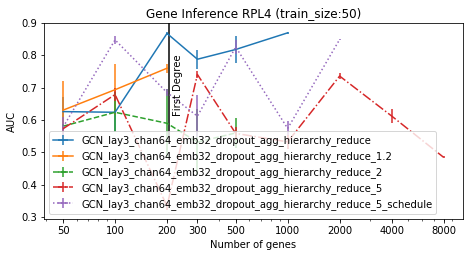

In [54]:
search_genes = ["RPL4"]
for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print(fd)
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()